In [98]:
# Import libraries
import os
import os
import scipy.io as sio

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
from scipy.integrate import simpson  
import pandas as pd

## Loading the Dataset

In [99]:
data_path = "dataset"

files = sorted([f for f in os.listdir(data_path) if f.endswith(".mat")])
print("Number of subjects:", len(files))
print(files)


Number of subjects: 27
['S10_A1_E1.mat', 'S11_A1_E1.mat', 'S12_A1_E1.mat', 'S13_A1_E1.mat', 'S14_A1_E1.mat', 'S15_A1_E1.mat', 'S16_A1_E1.mat', 'S17_A1_E1.mat', 'S18_A1_E1.mat', 'S19_A1_E1.mat', 'S1_A1_E1.mat', 'S20_A1_E1.mat', 'S21_A1_E1.mat', 'S22_A1_E1.mat', 'S23_A1_E1.mat', 'S24_A1_E1.mat', 'S25_A1_E1.mat', 'S26_A1_E1.mat', 'S27_A1_E1.mat', 'S2_A1_E1.mat', 'S3_A1_E1.mat', 'S4_A1_E1.mat', 'S5_A1_E1.mat', 'S6_A1_E1.mat', 'S7_A1_E1.mat', 'S8_A1_E1.mat', 'S9_A1_E1.mat']


In [100]:
all_subjects = []

for fname in files:
    fpath = os.path.join(data_path, fname)
    data = sio.loadmat(fpath)
    
    # Correct fields
    emg         = data["emg"]              # (N, 10)
    stimulus    = data["restimulus"].ravel()    # processed labels
    repetition  = data["rerepetition"].ravel()  # processed repetitions
    
    # Optional: rectified copy (we can use abs() later)
    emg_rectified = emg.copy()
    
    # Sanity check: same length
    assert emg.shape[0] == stimulus.shape[0] == repetition.shape[0], \
        f"Length mismatch in {fname}"
    
    subj = {
        "name": fname,
        "emg": emg,
        "emg_rectified": emg_rectified,
        "stimulus": stimulus,
        "repetition": repetition,
    }
    all_subjects.append(subj)

print("Loaded", len(all_subjects), "subjects.")

Loaded 27 subjects.


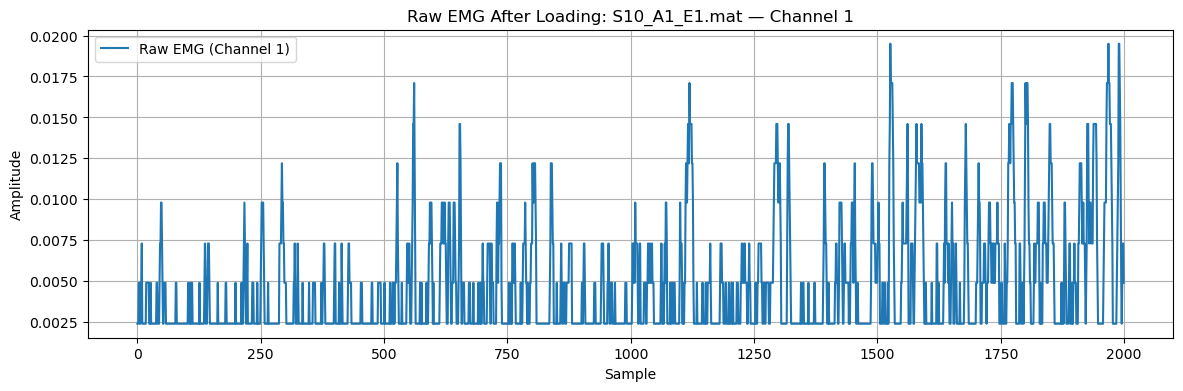

In [101]:
import matplotlib.pyplot as plt

# Pick the first subject and the first EMG channel
subj = all_subjects[0]
emg_raw = subj["emg"][:, 0]    # channel 1

# Plot first 2000 samples (20 seconds at 100 Hz)
plt.figure(figsize=(14,4))
plt.plot(emg_raw[:2000], label="Raw EMG (Channel 1)")
plt.title(f"Raw EMG After Loading: {subj['name']} — Channel 1")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()


In [102]:
for subj in all_subjects:
    print(f"\n{subj['name']}:")
    print("  EMG shape:", subj["emg"].shape)
    print("  Stimulus shape:", subj["stimulus"].shape,
          "unique:", np.unique(subj["stimulus"]))
    print("  Repetition shape:", subj["repetition"].shape,
          "unique:", np.unique(subj["repetition"]))


S10_A1_E1.mat:
  EMG shape: (100778, 10)
  Stimulus shape: (100778,) unique: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
  Repetition shape: (100778,) unique: [ 0  1  2  3  4  5  6  7  8  9 10]

S11_A1_E1.mat:
  EMG shape: (100899, 10)
  Stimulus shape: (100899,) unique: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
  Repetition shape: (100899,) unique: [ 0  1  2  3  4  5  6  7  8  9 10]

S12_A1_E1.mat:
  EMG shape: (100920, 10)
  Stimulus shape: (100920,) unique: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
  Repetition shape: (100920,) unique: [ 0  1  2  3  4  5  6  7  8  9 10]

S13_A1_E1.mat:
  EMG shape: (100948, 10)
  Stimulus shape: (100948,) unique: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
  Repetition shape: (100948,) unique: [ 0  1  2  3  4  5  6  7  8  9 10]

S14_A1_E1.mat:
  EMG shape: (100785, 10)
  Stimulus shape: (100785,) unique: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
  Repetition shape: (100785,) unique: [ 0  1  2  3  4  5  6  7  8  9 10]

S15_A1_E1.mat:
  EMG shape: (101508, 10

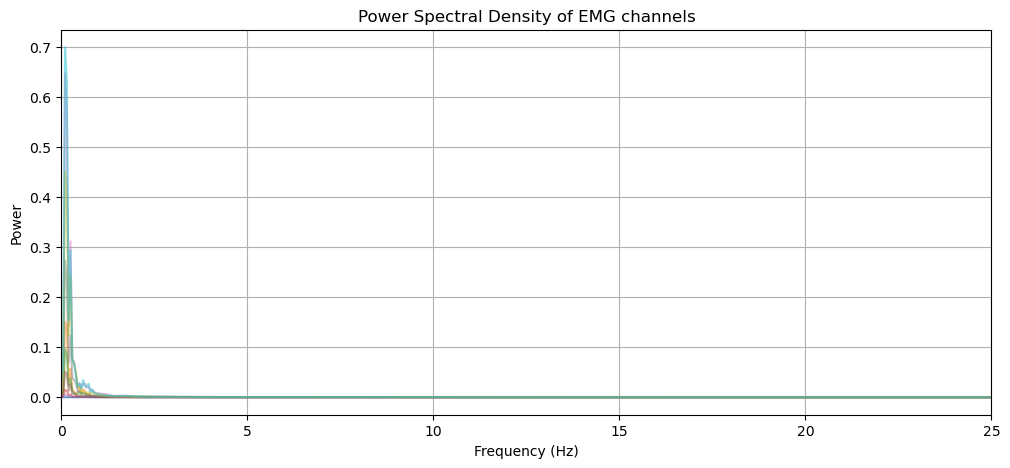

In [103]:
import matplotlib.pyplot as plt
from scipy.signal import welch

subj = all_subjects[0]          # check first subject
emg = subj["emg"]

fs = 100  # sampling rate

plt.figure(figsize=(12,5))

for ch in range(10):
    f, Pxx = welch(emg[:, ch], fs=fs, nperseg=2048)
    plt.plot(f, Pxx, alpha=0.5)

plt.title("Power Spectral Density of EMG channels")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.xlim(0, 25)
plt.grid(True)
plt.show()


## Windowing

In [104]:
import numpy as np

n_stimuli = 12
n_repetitions = 10

# Structure: emg_windows[stimulus][repetition] = EMG matrix (time × channels)
emg_windows = [[None for _ in range(n_repetitions)] 
               for _ in range(n_stimuli)]

for subj in all_subjects:

    emg = subj["emg"]                 # already processed EMG envelope
    stimulus = subj["stimulus"]
    repetition = subj["repetition"]

    for stim_idx in range(n_stimuli):
        for rep_idx in range(n_repetitions):

            # Create mask for this trial
            idx = np.logical_and(stimulus == stim_idx + 1,
                                 repetition == rep_idx + 1)

            # Extract EMG window for this trial
            current_window = emg[idx, :]

            # Store it
            emg_windows[stim_idx][rep_idx] = current_window


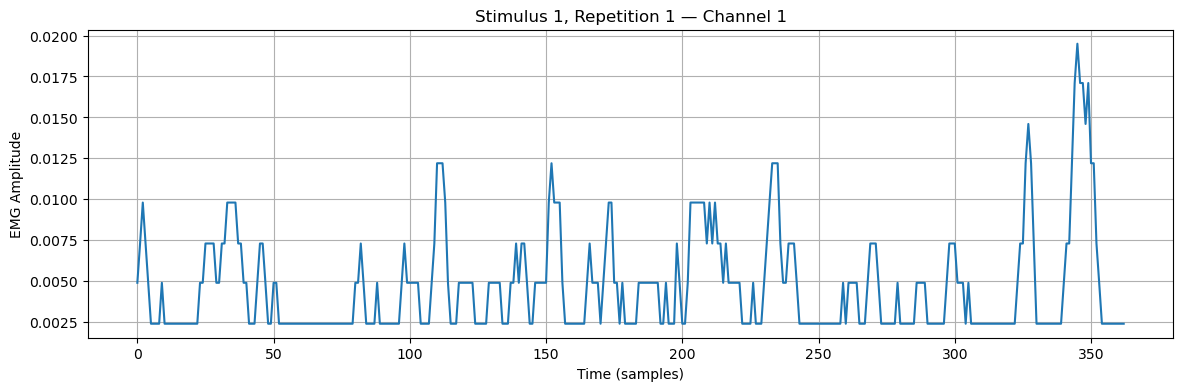

In [105]:
import matplotlib.pyplot as plt

stim_idx = 0
rep_idx = 0

window = emg_windows[stim_idx][rep_idx]

plt.figure(figsize=(14,4))
plt.plot(window[:, 0])
plt.title(f"Stimulus {stim_idx+1}, Repetition {rep_idx+1} — Channel 1")
plt.xlabel("Time (samples)")
plt.ylabel("EMG Amplitude")
plt.grid(True)
plt.show()

In [106]:
n_stimuli = 12
n_repetitions = 10

subject_windows = []   # list for each subject

for subj in all_subjects:

    emg = subj["emg"]
    stimulus = subj["stimulus"]
    repetition = subj["repetition"]

    # windows for THIS subject
    emg_windows_subj = [[None for _ in range(n_repetitions)] 
                         for _ in range(n_stimuli)]

    for stim_idx in range(n_stimuli):
        for rep_idx in range(n_repetitions):

            idx = np.logical_and(stimulus == stim_idx + 1,
                                 repetition == rep_idx + 1)

            emg_windows_subj[stim_idx][rep_idx] = emg[idx, :]

    subject_windows.append(emg_windows_subj)

print("Subjects processed:", len(subject_windows))

Subjects processed: 27


## Feature Exctraction

In [107]:
import numpy as np
from scipy.signal import welch
import pywt

# -------------------------------------------------
# Feature definitions (per channel)
# -------------------------------------------------

# 1. Root Mean Square (RMS)
def feat_rms(x):
    return np.sqrt(np.mean(x**2, axis=0))

# 2. Mean Absolute Value (MAV)
def feat_mav(x):
    return np.mean(np.abs(x), axis=0)

# 3. Waveform Length (WL)
def feat_wl(x):
    return np.sum(np.abs(np.diff(x, axis=0)), axis=0)

# 4. Slope Sign Changes (SSC)
def feat_ssc(x):
    dx = np.diff(x, axis=0)
    return np.sum(dx[:-1] * dx[1:] < 0, axis=0)

# 5. Integrated EMG (IEMG)
def feat_iemg(x):
    return np.sum(np.abs(x), axis=0)

# 6. Variance
def feat_var(x):
    return np.var(x, axis=0)

# 7. Willison Amplitude (WAMP)
def feat_wamp(x, threshold=0.01):
    return np.sum(np.abs(np.diff(x, axis=0)) > threshold, axis=0)

# 8. Histogram of log-amplitude entropy
def feat_hist_log(x, bins=20):
    n_ch = x.shape[1]
    out = np.zeros(n_ch)

    for ch in range(n_ch):
        sig = np.log10(np.abs(x[:, ch]) + 1e-12)
        hist, _ = np.histogram(sig, bins=bins, density=True)
        p = hist / (np.sum(hist) + 1e-12)
        out[ch] = -np.sum(p * np.log(p + 1e-12))

    return out

# 9. Marginal Discrete Wavelet Transform (MDWT)
def feat_mdwt(x, wavelet="sym4", level=3):
    n_ch = x.shape[1]
    out = np.zeros(n_ch)

    w = pywt.Wavelet(wavelet)

    for ch in range(n_ch):
        sig = x[:, ch]
        max_level = pywt.dwt_max_level(len(sig), w.dec_len)
        use_level = min(level, max_level)
        coeffs = pywt.wavedec(sig, wavelet, level=use_level)
        out[ch] = np.sum([np.sum(np.abs(c)) for c in coeffs])

    return out

# 10. Power Spectral Density (mean PSD per channel)
def feat_psd(x, fs=100, nperseg=None):
    if nperseg is None:
        nperseg = min(256, x.shape[0])
    freqs, psd_vals = welch(x, fs=fs, nperseg=nperseg, axis=0)
    return np.mean(psd_vals, axis=0)

# -------------------------------------------------
# Combined feature vector for one window
# -------------------------------------------------

def extract_features(window, fs=100):
    feats = []

    feats.append(feat_rms(window))
    feats.append(feat_mav(window))
    feats.append(feat_wl(window))
    feats.append(feat_ssc(window))
    feats.append(feat_iemg(window))
    feats.append(feat_var(window))
    feats.append(feat_wamp(window))
    feats.append(feat_hist_log(window))
    feats.append(feat_mdwt(window))
    feats.append(feat_psd(window, fs))

    return np.concatenate(feats)

In [108]:
def generate_feature_names(n_channels=10):
    names = []

    # 1. RMS
    for ch in range(n_channels):
        names.append(f"RMS_ch{ch+1}")

    # 2. MAV
    for ch in range(n_channels):
        names.append(f"MAV_ch{ch+1}")

    # 3. Waveform Length (WL)
    for ch in range(n_channels):
        names.append(f"WL_ch{ch+1}")

    # 4. Slope Sign Changes (SSC)
    for ch in range(n_channels):
        names.append(f"SSC_ch{ch+1}")

    # 5. Integrated EMG (IEMG)
    for ch in range(n_channels):
        names.append(f"IEMG_ch{ch+1}")

    # 6. Variance
    for ch in range(n_channels):
        names.append(f"VAR_ch{ch+1}")

    # 7. Willison Amplitude (WAMP)
    for ch in range(n_channels):
        names.append(f"WAMP_ch{ch+1}")

    # 8. Histogram of log-amplitude entropy
    for ch in range(n_channels):
        names.append(f"HISTLOG_ch{ch+1}")

    # 9. Marginal Discrete Wavelet Transform (MDWT)
    for ch in range(n_channels):
        names.append(f"MDWT_ch{ch+1}")

    # 10. Power Spectral Density (PSD)
    for ch in range(n_channels):
        names.append(f"PSD_ch{ch+1}")

    return names


# Create the feature name list
feature_names = generate_feature_names(n_channels=10)

# Sanity check
print("Total number of features:", len(feature_names))

Total number of features: 100


In [109]:
subject_feature_means = []   # each entry = mean feature vector for subject
subject_feature_stds  = []   # each entry = std feature vector for subject

for subj_idx in range(len(subject_windows)):

    X_sub = []    # all feature vectors for this subject

    for stim_idx in range(n_stimuli):
        for rep_idx in range(n_repetitions):
            win = subject_windows[subj_idx][stim_idx][rep_idx]
            if win is None or len(win) == 0:
                continue
            X_sub.append(extract_features(win))

    X_sub = np.vstack(X_sub)

    subject_feature_means.append(np.mean(X_sub, axis=0))
    subject_feature_stds.append(np.std(X_sub, axis=0))


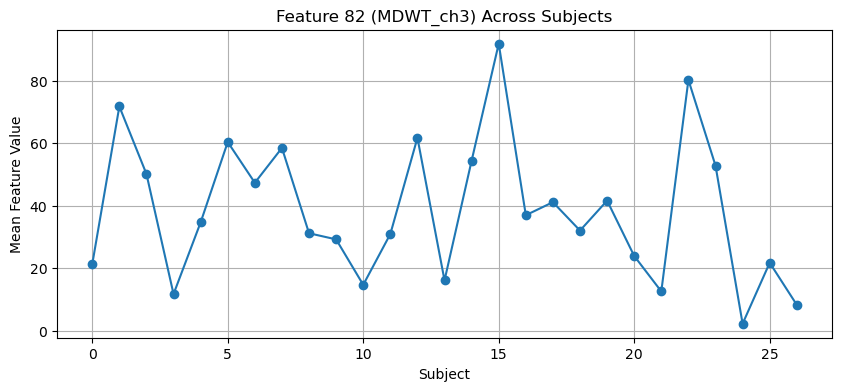

In [111]:
feat_idx = 82  # for example, RMS_ch7

plt.figure(figsize=(10,4))
plt.plot([mean[feat_idx] for mean in subject_feature_means], marker='o')
plt.title(f"Feature {feat_idx} ({feature_names[feat_idx]}) Across Subjects")
plt.xlabel("Subject")
plt.ylabel("Mean Feature Value")
plt.grid(True)
plt.show()


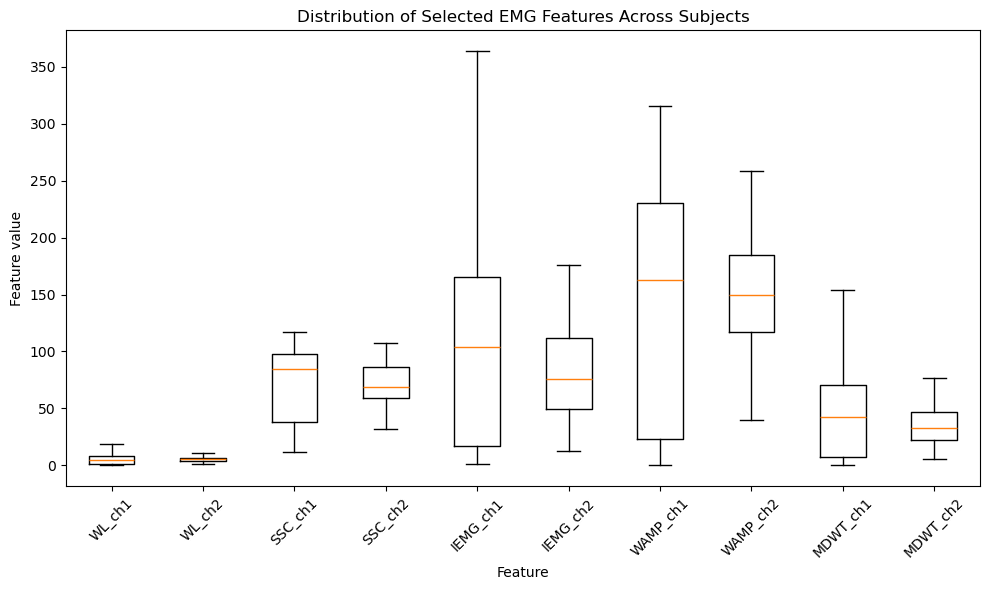

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------
# Convert list to array
# ----------------------------------------------------
subject_feature_means = np.array(subject_feature_means)  # shape: (n_subjects, n_features)

# ----------------------------------------------------
# Manually select requested features (by index)
# ----------------------------------------------------
feature_indices = [20, 21, 30, 31, 40, 41, 60, 61, 80, 81]
# the rest of the features: [0, 1, 10, 11, 50, 51, 70, 71,  90, 91]
features_to_plot = [feature_names[i] for i in feature_indices]

# ----------------------------------------------------
# Boxplot: feature distributions across subjects
# ----------------------------------------------------
plt.figure(figsize=(10, 6))

data = [subject_feature_means[:, idx] for idx in feature_indices]

plt.boxplot(data, showfliers=False)
plt.xticks(range(1, len(features_to_plot) + 1), features_to_plot, rotation=45)
plt.ylabel("Feature value")
plt.xlabel("Feature")
plt.title("Distribution of Selected EMG Features Across Subjects")

plt.tight_layout()
plt.show()


## Feature Selection

We can simply skip selecting features as we already have a few number of features !

In [ ]:
# X = []
# Y = []

# for stim_idx in range(n_stimuli):
#     for rep_idx in range(n_repetitions):

#         window = emg_windows[stim_idx][rep_idx]

#         if window is None or len(window) == 0:
#             continue

#         fv = extract_features(window)   # feature vector
#         X.append(fv)
#         Y.append(stim_idx + 1)          # class label

# X = np.vstack(X)
# Y = np.array(Y)


In [ ]:
# print("X shape:", X.shape)
# print("Y shape:", Y.shape)
# print("Number of features:", X.shape[1])
# print("Number of samples:", X.shape[0])

X shape: (120, 100)
Y shape: (120,)
Number of features: 100
Number of samples: 120


In [ ]:
# from sklearn.impute import SimpleImputer

# imputer = SimpleImputer(strategy="mean")
# X = imputer.fit_transform(X)

# print("NaN left:", np.isnan(X).sum())

NaN left: 0


In [ ]:
# from sklearn.feature_selection import mutual_info_classif

# # Compute Mutual Information for each feature
# MI = mutual_info_classif(X, Y, discrete_features=False)

# # Sort features by MI (descending)
# mi_rank = np.argsort(MI)[::-1]

# # Top 5 features
# top60_mi = mi_rank[:60]


# print("\nNames:")
# for idx in top60_mi:
#     print(idx, feature_names[idx])

## Classification + Cross-Validation

In [118]:
from sklearn.preprocessing import StandardScaler

subject_features = []

for subj_idx in range(len(subject_windows)):
    X_sub = []
    Y_sub = []

    # --- extract features for this subject ---
    for stim_idx in range(n_stimuli):
        for rep_idx in range(n_repetitions):
            win = subject_windows[subj_idx][stim_idx][rep_idx]
            if win is None or len(win) == 0:
                continue

            fv = extract_features(win)
            X_sub.append(fv)
            Y_sub.append(stim_idx + 1)

    # --- convert to arrays ---
    X_sub = np.vstack(X_sub)
    Y_sub = np.array(Y_sub)

    # --- 1) remove NaN ---
    imputer = SimpleImputer(strategy="mean")
    X_sub = imputer.fit_transform(X_sub)

    # --- 2) normalize THIS SUBJECT ONLY ---
    scaler = StandardScaler()
    X_sub = scaler.fit_transform(X_sub)

    # --- store clean data ---
    subject_features.append({
        "X": X_sub,
        "Y": Y_sub
    })

print("Done building normalized subject_features.")


Done building normalized subject_features.


In [119]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

loso_accuracies = []
loso_predictions = []

for test_idx in range(len(subject_features)):

    # Build training set from the other 26 subjects
    X_train = []
    Y_train = []

    for i in range(len(subject_features)):
        if i != test_idx:
            X_train.append(subject_features[i]["X"])
            Y_train.append(subject_features[i]["Y"])

    X_train = np.vstack(X_train)
    Y_train = np.hstack(Y_train)

    # Test subject
    X_test = subject_features[test_idx]["X"]
    Y_test = subject_features[test_idx]["Y"]

    # Train the SVM
    clf = SVC(kernel='rbf', C=10, gamma='scale')
    clf.fit(X_train, Y_train)

    # Predict
    Y_pred = clf.predict(X_test)
    loso_predictions.append((Y_test, Y_pred))

    # Accuracy
    acc = accuracy_score(Y_test, Y_pred)
    loso_accuracies.append(acc)
    
    print(f"Subject {test_idx+1}: LOSO accuracy = {acc:.3f}")

# Summary
print("\nMean LOSO accuracy:", np.mean(loso_accuracies))
print("STD across subjects:", np.std(loso_accuracies))


Subject 1: LOSO accuracy = 0.467
Subject 2: LOSO accuracy = 0.433
Subject 3: LOSO accuracy = 0.467
Subject 4: LOSO accuracy = 0.458
Subject 5: LOSO accuracy = 0.475
Subject 6: LOSO accuracy = 0.500
Subject 7: LOSO accuracy = 0.442
Subject 8: LOSO accuracy = 0.650
Subject 9: LOSO accuracy = 0.417
Subject 10: LOSO accuracy = 0.350
Subject 11: LOSO accuracy = 0.383
Subject 12: LOSO accuracy = 0.517
Subject 13: LOSO accuracy = 0.617
Subject 14: LOSO accuracy = 0.400
Subject 15: LOSO accuracy = 0.483
Subject 16: LOSO accuracy = 0.417
Subject 17: LOSO accuracy = 0.600
Subject 18: LOSO accuracy = 0.667
Subject 19: LOSO accuracy = 0.308
Subject 20: LOSO accuracy = 0.058
Subject 21: LOSO accuracy = 0.500
Subject 22: LOSO accuracy = 0.292
Subject 23: LOSO accuracy = 0.458
Subject 24: LOSO accuracy = 0.367
Subject 25: LOSO accuracy = 0.183
Subject 26: LOSO accuracy = 0.558
Subject 27: LOSO accuracy = 0.325

Mean LOSO accuracy: 0.4367283950617284
STD across subjects: 0.13162992258154432


In [121]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

within_acc = []

for subj_idx in range(len(subject_features)):

    X = subject_features[subj_idx]["X"]
    Y = subject_features[subj_idx]["Y"]

    # --- split first ---
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=0, stratify=Y
    )

    # --- normalize using TRAINING DATA ONLY ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    # --- train classifier ---
    clf = SVC(kernel='rbf', gamma='scale', C=10)
    clf.fit(X_train, Y_train)

    # --- evaluate ---
    Y_pred = clf.predict(X_test)
    acc = accuracy_score(Y_test, Y_pred)
    within_acc.append(acc)

    print(f"Subject {subj_idx+1}: Within-subject accuracy = {acc:.2f}")


Subject 1: Within-subject accuracy = 0.83
Subject 2: Within-subject accuracy = 0.96
Subject 3: Within-subject accuracy = 0.92
Subject 4: Within-subject accuracy = 0.96
Subject 5: Within-subject accuracy = 0.92
Subject 6: Within-subject accuracy = 0.92
Subject 7: Within-subject accuracy = 0.88
Subject 8: Within-subject accuracy = 0.88
Subject 9: Within-subject accuracy = 0.96
Subject 10: Within-subject accuracy = 0.88
Subject 11: Within-subject accuracy = 0.79
Subject 12: Within-subject accuracy = 1.00
Subject 13: Within-subject accuracy = 0.88
Subject 14: Within-subject accuracy = 0.92
Subject 15: Within-subject accuracy = 0.92
Subject 16: Within-subject accuracy = 0.79
Subject 17: Within-subject accuracy = 0.96
Subject 18: Within-subject accuracy = 1.00
Subject 19: Within-subject accuracy = 0.79
Subject 20: Within-subject accuracy = 0.83
Subject 21: Within-subject accuracy = 0.96
Subject 22: Within-subject accuracy = 0.92
Subject 23: Within-subject accuracy = 0.96
Subject 24: Within-s

use the same method as part one (splitting based on the repetition lables)

In [93]:
# trial-level stimulus & repetition labels (length = 120)
trial_stimulus = []
trial_repetition = []

for stim_idx in range(n_stimuli):
    for rep_idx in range(n_repetitions):
        trial_stimulus.append(stim_idx + 1)
        trial_repetition.append(rep_idx + 1)

trial_stimulus = np.array(trial_stimulus)
trial_repetition = np.array(trial_repetition)


In [94]:
import numpy as np

def balanced_split(stimulus, repetition, seed=42, ignore_stimulus=(0,)):
    stimulus = np.asarray(stimulus).reshape(-1)
    repetition = np.asarray(repetition).reshape(-1)
    assert stimulus.shape == repetition.shape

    rng = np.random.default_rng(seed)

    rep_split = {}
    train_mask = np.zeros_like(stimulus, dtype=bool)
    val_mask   = np.zeros_like(stimulus, dtype=bool)
    test_mask  = np.zeros_like(stimulus, dtype=bool)

    stim_ids = [s for s in np.unique(stimulus) if s not in ignore_stimulus]

    for s in stim_ids:
        reps = np.unique(repetition[stimulus == s])
        reps = reps[reps != 0]  

        if len(reps) != 10:
            raise ValueError(f"Stimulus {s} has {len(reps)} reps (expected 10): {reps}")

        # random permutation, then 7/2/1 train/val/test split
        reps = rng.permutation(reps)
        train_reps = reps[:7]
        val_reps   = reps[7:9]
        test_reps  = reps[9:]

        rep_split[s] = {
            "train": train_reps.tolist(),
            "val":   val_reps.tolist(),
            "test":  test_reps.tolist()
        }

        s_mask = (stimulus == s)
        train_mask |= s_mask & np.isin(repetition, train_reps)
        val_mask   |= s_mask & np.isin(repetition, val_reps)
        test_mask  |= s_mask & np.isin(repetition, test_reps)

    # to ensure train/val/test disjoint
    assert not np.any(train_mask & val_mask)
    assert not np.any(train_mask & test_mask)
    assert not np.any(val_mask & test_mask)

    return rep_split, train_mask, val_mask, test_mask


In [95]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

within_acc = []

for subj_idx in range(len(subject_features)):

    X = subject_features[subj_idx]["X"]   # shape (120, n_features)
    Y = subject_features[subj_idx]["Y"]   # shape (120,)

    # --- repetition-based split at TRIAL level ---
    _, train_mask, _, test_mask = balanced_split(
        stimulus=trial_stimulus,
        repetition=trial_repetition
    )

    X_train = X[train_mask]
    Y_train = Y[train_mask]
    X_test  = X[test_mask]
    Y_test  = Y[test_mask]

    # --- normalize using TRAINING DATA ONLY ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    # --- train classifier ---
    clf = SVC(kernel='rbf', C=10, gamma='scale')
    clf.fit(X_train, Y_train)

    # --- evaluate ---
    Y_pred = clf.predict(X_test)
    acc = accuracy_score(Y_test, Y_pred)
    within_acc.append(acc)

    print(f"Subject {subj_idx+1:2d}: Within-subject accuracy = {acc:.2f}")


Subject  1: Within-subject accuracy = 1.00
Subject  2: Within-subject accuracy = 0.83
Subject  3: Within-subject accuracy = 0.83
Subject  4: Within-subject accuracy = 0.92
Subject  5: Within-subject accuracy = 1.00
Subject  6: Within-subject accuracy = 1.00
Subject  7: Within-subject accuracy = 0.83
Subject  8: Within-subject accuracy = 0.83
Subject  9: Within-subject accuracy = 0.83
Subject 10: Within-subject accuracy = 0.83
Subject 11: Within-subject accuracy = 0.92
Subject 12: Within-subject accuracy = 1.00
Subject 13: Within-subject accuracy = 1.00
Subject 14: Within-subject accuracy = 1.00
Subject 15: Within-subject accuracy = 1.00
Subject 16: Within-subject accuracy = 0.92
Subject 17: Within-subject accuracy = 1.00
Subject 18: Within-subject accuracy = 1.00
Subject 19: Within-subject accuracy = 0.83
Subject 20: Within-subject accuracy = 0.83
Subject 21: Within-subject accuracy = 0.92
Subject 22: Within-subject accuracy = 0.92
Subject 23: Within-subject accuracy = 1.00
Subject 24:

In [122]:
print("\n=== SUMMARY ===")
print(
    f"Mean LOSO accuracy (cross-subject): "
    f"{np.mean(loso_accuracies):.2f} ± {np.std(loso_accuracies):.2f}"
)
print(
    f"Mean within-subject accuracy: "
    f"{np.mean(within_acc):.2f} ± {np.std(within_acc):.2f}"
)



=== SUMMARY ===
Mean LOSO accuracy (cross-subject): 0.44 ± 0.13
Mean within-subject accuracy: 0.90 ± 0.06


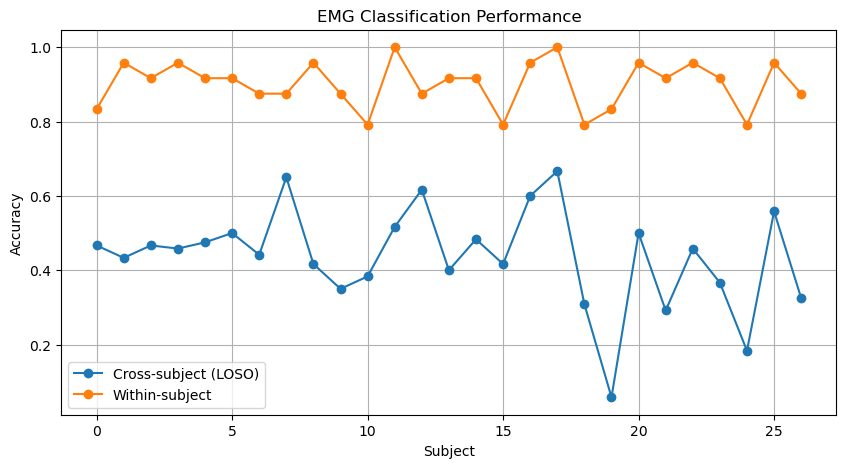

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.plot(
    loso_accuracies,
    marker='o',
    linestyle='-',
    label="Cross-subject (LOSO)"
)

plt.plot(
    within_acc,
    marker='o',
    linestyle='-',
    label="Within-subject"
)

plt.title("EMG Classification Performance")
plt.xlabel("Subject")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


The LOSO cross-validation evaluates how well the model generalizes to a subject that was never seen during training. The results show a large drop in accuracy compared to within-subject evaluation. This happens because EMG signals vary strongly between subjects due to differences in muscle physiology, skin impedance, electrode placement, and activation patterns. As a result, a model trained on 26 subjects transfers only partially to the remaining subject.

## Decoder (Optimal number of subjects for training)

Train subjects:  1, accuracy on subject 18: 0.092
Train subjects:  2, accuracy on subject 18: 0.050
Train subjects:  3, accuracy on subject 18: 0.217
Train subjects:  4, accuracy on subject 18: 0.175
Train subjects:  5, accuracy on subject 18: 0.250
Train subjects:  6, accuracy on subject 18: 0.325
Train subjects:  7, accuracy on subject 18: 0.375
Train subjects:  8, accuracy on subject 18: 0.483
Train subjects:  9, accuracy on subject 18: 0.467
Train subjects: 10, accuracy on subject 18: 0.558
Train subjects: 11, accuracy on subject 18: 0.558
Train subjects: 12, accuracy on subject 18: 0.592
Train subjects: 13, accuracy on subject 18: 0.633
Train subjects: 14, accuracy on subject 18: 0.633
Train subjects: 15, accuracy on subject 18: 0.658
Train subjects: 16, accuracy on subject 18: 0.667
Train subjects: 17, accuracy on subject 18: 0.667
Train subjects: 18, accuracy on subject 18: 0.633
Train subjects: 19, accuracy on subject 18: 0.658
Train subjects: 20, accuracy on subject 18: 0.642


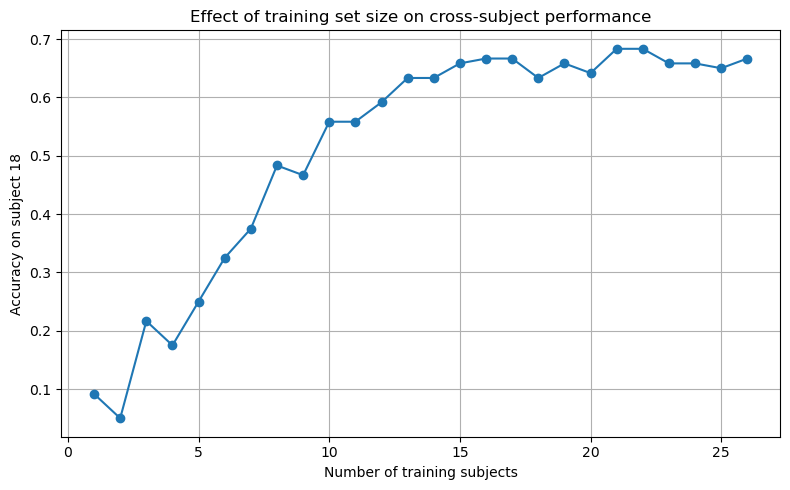

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

n_subjects = len(subject_features)
test_idx = 17   # subject 27 (0-based index)

# training order: all subjects except test subject
train_order = [i for i in range(n_subjects) if i != test_idx]

acc_vs_n = []

for k in range(1, len(train_order) + 1):
    train_idxs = train_order[:k]

    X_train = np.vstack([subject_features[i]["X"] for i in train_idxs])
    Y_train = np.hstack([subject_features[i]["Y"] for i in train_idxs])

    X_test = subject_features[test_idx]["X"]
    Y_test = subject_features[test_idx]["Y"]

    # --- normalize using TRAINING DATA ONLY ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    # --- train classifier ---
    clf = SVC(kernel='rbf', C=10, gamma='scale')
    clf.fit(X_train, Y_train)

    # --- evaluate ---
    Y_pred = clf.predict(X_test)
    acc = accuracy_score(Y_test, Y_pred)
    acc_vs_n.append(acc)

    print(f"Train subjects: {k:2d}, accuracy on subject {test_idx+1}: {acc:.3f}")

# --- plot ---
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_order) + 1), acc_vs_n, marker='o')
plt.xlabel("Number of training subjects")
plt.ylabel(f"Accuracy on subject {test_idx+1}")
plt.title("Effect of training set size on cross-subject performance")
plt.grid(True)
plt.tight_layout()
plt.show()


try for all subjects

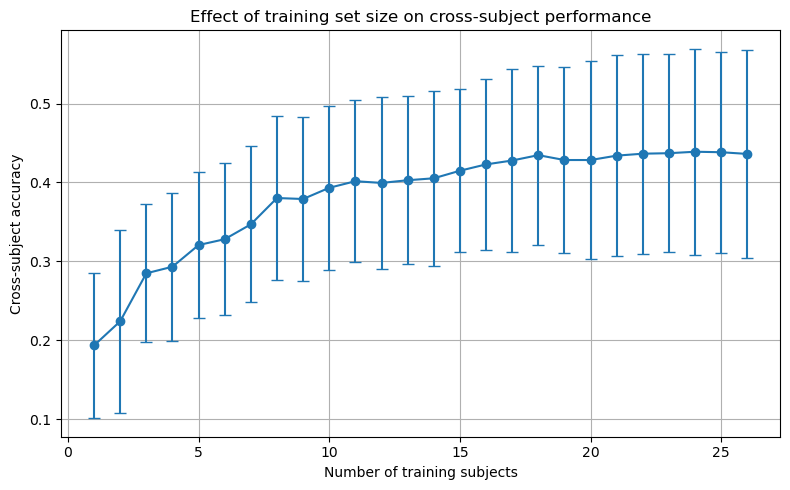

In [44]:
n_subjects = len(subject_features)

# shape: (n_subjects, n_subjects - 1)
all_acc_vs_n = []

for test_idx in range(n_subjects):

    # training order: all subjects except test subject
    train_order = [i for i in range(n_subjects) if i != test_idx]

    acc_vs_n = []

    for k in range(1, len(train_order) + 1):
        train_idxs = train_order[:k]

        X_train = np.vstack([subject_features[i]["X"] for i in train_idxs])
        Y_train = np.hstack([subject_features[i]["Y"] for i in train_idxs])

        X_test = subject_features[test_idx]["X"]
        Y_test = subject_features[test_idx]["Y"]

        # --- NORMALIZE USING TRAINING DATA ONLY ---
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test  = scaler.transform(X_test)

        # --- Train classifier ---
        clf = SVC(kernel='rbf', C=10, gamma='scale')
        clf.fit(X_train, Y_train)

        # --- Evaluate ---
        Y_pred = clf.predict(X_test)
        acc = accuracy_score(Y_test, Y_pred)
        acc_vs_n.append(acc)

    all_acc_vs_n.append(acc_vs_n)

all_acc_vs_n = np.array(all_acc_vs_n)  # shape: (n_subjects, n_subjects - 1)

# ----------------------------------------------------
# Compute mean and STD across test subjects
# ----------------------------------------------------
mean_acc = np.mean(all_acc_vs_n, axis=0)
std_acc  = np.std(all_acc_vs_n, axis=0)

# ----------------------------------------------------
# Plot mean ± STD
# ----------------------------------------------------
plt.figure(figsize=(8,5))
x = np.arange(1, n_subjects)

plt.errorbar(
    x,
    mean_acc,
    yerr=std_acc,
    marker='o',
    capsize=4
)

plt.xlabel("Number of training subjects")
plt.ylabel("Cross-subject accuracy")
plt.title("Effect of training set size on cross-subject performance")
plt.grid(True)
plt.tight_layout()
plt.show()